In [10]:
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier, export_text

In [11]:
# Load (updated 18.11.2025) data
pd.set_option("display.max_columns", 50)
DATA_PATH = Path("dataset1-copy.xlsx")

raw = pd.read_excel(DATA_PATH)
print(f"Loaded {raw.shape[0]:,} rows × {raw.shape[1]} columns")
print(f"Number of patients: {len(raw['uid'].unique())}")
raw.head()

Loaded 10,374 rows × 29 columns
Number of patients: 4978


,uid,sex,fdr,any_fdr,source,screening_info,sample_date,age_at_sample,elisa,lips_unin_iaa,lips_in_iaa,hbg_lips_in_iaa,m_iaa,gada_trunc,ia2,znt8_c_arg,znt8_c_tryp,iaa_status_fu,gadatrunc_status_fu,ia2_status_fu,zink_status_fu,all_reports_screening,final_report_screening,reevaluated,hemolyzed,sample_empty,lab,last_contact_or_t1d_date,last_contact_date_type
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0.0,NaN,NaN,screening,NaN,2016-11-11,3.78,132.320000,NaN,NaN,NaN,1.0,8.5,0.1,0.1,0.1,NaN,NaN,NaN,NaN,negative,negative,NaN,NaN,NaN,Munich,2025-11-18,current_date
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,screening,NaN,2021-05-11,3.10,1.335415,19.007826,42.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,dropout_date
2,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,screening,NaN,2021-06-17,3.21,NaN,NaN,28.9,NaN,14.7,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,dropout_date
3,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,NaN,follow_up,NaN,2022-07-01,4.24,NaN,NaN,NaN,NaN,30.6,0.1,0.1,0.1,0.1,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Munich,2023-06-19,dropout_date
4,005B2E43-F96E-406F-AB19-BECB1692A4C6,1.0,NaN,NaN,screening,NaN,2015-09-09,3.92,26.920000,NaN,NaN,NaN,0.7,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,negative,negative,NaN,NaN,NaN,Munich,2025-11-18,current_date


### 1. Data Setup & Quality Checks

In [12]:
NUMERIC_WITH_COMMA = [
    "elisa",
    "lips_unin_iaa",
    "lips_in_iaa",
    "m_iaa",
    "gada_trunc",
    "ia2",
    "znt8_c_arg",
    "znt8_c_tryp",
    "age_at_sample",
]

DATE_COLS = ["sample_date", "last_contact_or_t1d_date"]

FOLLOWUP_STATUS_COLS = [
    "iaa_status_fu",
    "gadatrunc_status_fu",
    "ia2_status_fu",
    "zink_status_fu",
]

def clean_raw(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # -----------------------------------
    # 1) Normalize numeric assay columns
    # -----------------------------------
    for col in NUMERIC_WITH_COMMA:
        if col in out:
            out[col] = (
                out[col]
                .astype(str)
                .str.replace(",", ".", regex=False)
                .replace({"": np.nan, "nan": np.nan})
                .astype(float)
            )

    # -----------------------------------
    # 2) Parse date columns
    # -----------------------------------
    for col in DATE_COLS:
        if col in out:
            out[col] = pd.to_datetime(out[col], errors="coerce")

    # -----------------------------------
    # 3) Clean FDR (family history) variables
    # -----------------------------------
    # fdr = which relative has T1D (string)
    # any_fdr = binary flag (1=yes, 0=no)
    if "fdr" in out:
        out["fdr"] = out["fdr"].astype(str)
        out["fdr"] = out["fdr"].replace({"nan": np.nan, "": np.nan})

    # Create a clean binary FDR flag based on fdr column
    out["any_fdr"] = out["fdr"].notna().astype(int)

    # -----------------------------------
    # 4) Clean follow-up status flags
    # -----------------------------------
    # 0 = negative, 1 = positive, NaN = no follow-up → set to 0
    for col in FOLLOWUP_STATUS_COLS:
        if col in out:
            out[col] = out[col].fillna(0).astype(int)

    # -----------------------------------
    # 5) Hemoglobin interference flag
    # -----------------------------------
    if "hbg_lips_in_iaa" in out:
        out["hbg_lips_in_iaa"] = out["hbg_lips_in_iaa"].fillna(0).astype(int)

    # -----------------------------------
    # 6) Clean `source`
    # -----------------------------------
    if "source" in out:
        out["source"] = out["source"].astype(str).str.lower().str.strip()
        out["source"] = out["source"].replace("nan", np.nan)

    # -----------------------------------
    # 7) Clean categorical fields
    # -----------------------------------
    CAT_COLS = ["final_report_screening", "last_contact_date_type", "sex"]
    for col in CAT_COLS:
        if col in out:
            out[col] = out[col].replace({"nan": np.nan, "": np.nan})

    return out

In [13]:
data = clean_raw(raw)
data.head()

,uid,sex,fdr,any_fdr,source,screening_info,sample_date,age_at_sample,elisa,lips_unin_iaa,lips_in_iaa,hbg_lips_in_iaa,m_iaa,gada_trunc,ia2,znt8_c_arg,znt8_c_tryp,iaa_status_fu,gadatrunc_status_fu,ia2_status_fu,zink_status_fu,all_reports_screening,final_report_screening,reevaluated,hemolyzed,sample_empty,lab,last_contact_or_t1d_date,last_contact_date_type
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0.0,NaN,0,screening,NaN,2016-11-11,3.78,132.320000,NaN,NaN,0,1.0,8.5,0.1,0.1,0.1,0,0,0,0,negative,negative,NaN,NaN,NaN,Munich,2025-11-18,current_date
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,0,screening,NaN,2021-05-11,3.10,1.335415,19.007826,42.3,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,dropout_date
2,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,0,screening,NaN,2021-06-17,3.21,NaN,NaN,28.9,0,14.7,0.1,0.1,0.1,0.1,0,0,0,0,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,dropout_date
3,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,0,follow_up,NaN,2022-07-01,4.24,NaN,NaN,NaN,0,30.6,0.1,0.1,0.1,0.1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,Munich,2023-06-19,dropout_date
4,005B2E43-F96E-406F-AB19-BECB1692A4C6,1.0,NaN,0,screening,NaN,2015-09-09,3.92,26.920000,NaN,NaN,0,0.7,0.1,0.1,0.1,0.1,0,0,0,0,negative,negative,NaN,NaN,NaN,Munich,2025-11-18,current_date


In [14]:
# Check rows where `uid`, `sample_date`, `source` are missing
# Check for duplicates on key columns
KEY_COLS = ["uid", "sample_date", "source"]

# Check for duplicates on key columns
missing_key = data[KEY_COLS].isna().any(axis=1)
dups = data.duplicated(subset=KEY_COLS, keep=False)

print("Key coverage (uid, sample_date, source):")
print(
    pd.DataFrame(
        {
            "count": [len(data), missing_key.sum(), dups.sum()],
            "share": [1, missing_key.mean(), dups.mean()],
        },
        index=["rows", "missing component", "duplicate combination"],
    )
)

missing_examples = data.loc[missing_key, KEY_COLS + ["elisa", "final_report_screening"]]
print(f"\nRows with missing components: {missing_examples.shape[0]} rows")
if not missing_examples.empty:
    display(
        missing_examples.sort_values(KEY_COLS).head(10)
    )
# >>> end addition <<<

duplicated_examples = data.loc[dups, KEY_COLS + ["elisa", "final_report_screening"]]
print(f"\nDuplicate combos: {duplicated_examples.shape[0]} rows")
if not duplicated_examples.empty:
    display(
        duplicated_examples.sort_values(KEY_COLS).head(20)
    )

# Collect all uids with missing or duplicated key rows
uids_to_drop = set(data.loc[missing_key | dups, "uid"])

print(f"\nUIDs to drop (due to missing or duplicated keys): {len(uids_to_drop)}")

# Drop all rows associated with these uids
data = data[~data["uid"].isin(uids_to_drop)].copy()

print(f"Number of patients after: {len(data['uid'].unique())}")
print(f"Rows after cleaning: {len(data)}")
print(f"Total removed: {len(data) - len(data)}")



Key coverage (uid, sample_date, source):
                       count     share
rows                   10374  1.000000
missing component          4  0.000386
duplicate combination     18  0.001735

Rows with missing components: 4 rows


,uid,sample_date,source,elisa,final_report_screening
3486,52612EDD-8CD4-4FC0-9D04-E525AC5FFED0,NaT,antibody_follow_up,2.14,negative
6774,A7C411A7-9AD2-4DFD-A0D9-E2F82327074B,NaT,antibody_follow_up,5.70,negative
8265,CAB96359-7B38-4DB7-AA4E-B04638C8F6EB,NaT,antibody_follow_up,0.00,negative
9290,E2F4FCE7-F45C-4406-B5AD-9F1C494A9601,NaT,antibody_follow_up,1.83,negative



Duplicate combos: 18 rows


,uid,sample_date,source,elisa,final_report_screening
1110,1C4A423B-62CC-4B9C-B10F-88CAF4A57022,2015-09-21,screening,0.000,negative
1111,1C4A423B-62CC-4B9C-B10F-88CAF4A57022,2015-09-21,screening,NaN,negative
1474,245EA238-EA83-4DAA-8866-5F4E6EF7F696,2020-06-03,screening,1525.200,single_positive
1475,245EA238-EA83-4DAA-8866-5F4E6EF7F696,2020-06-03,screening,1177.600,single_positive
4615,6F783FB9-43F6-4668-8BE5-D054964BD555,2023-11-07,screening,NaN,multiple_positive
4616,6F783FB9-43F6-4668-8BE5-D054964BD555,2023-11-07,screening,NaN,multiple_positive
5418,8427950E-9312-4EA7-B332-37F51206C67F,2018-12-27,screening,58.262,negative
5419,8427950E-9312-4EA7-B332-37F51206C67F,2018-12-27,screening,NaN,negative
6090,943830AF-710A-4B79-B0C4-B6297D7B3592,2017-02-03,follow_up,NaN,NaN
6091,943830AF-710A-4B79-B0C4-B6297D7B3592,2017-02-03,follow_up,NaN,NaN



UIDs to drop (due to missing or duplicated keys): 13
Number of patients after: 4965
Rows after cleaning: 10312
Total removed: 0


In [15]:
# Coverage snapshot of follow-up data
CONFIRM_SOURCES = {"follow_up", "antibody_follow_up", "confirmation"}

uid_summary = (
    data
    .groupby("uid")
    .agg(
        n_rows=("uid", "size"),
        n_sample_dates=("sample_date", pd.Series.nunique),
        first_sample=("sample_date", "min"),
        last_sample=("sample_date", "max"),
        any_follow_up=("source", lambda x: x.isin(CONFIRM_SOURCES).any()),
        any_follow_up_data=("final_report_screening", lambda s: s.notna().any()),
    )
    .assign(
        span_days=lambda df: (df["last_sample"] - df["first_sample"]).dt.days,
    )
)

print("UID-level summary (first 5 rows):")
display(uid_summary.head())

coverage = {
    "total_uids": uid_summary.shape[0],
    "with_follow_up": uid_summary["any_follow_up"].mean(),
    "median_rows": uid_summary["n_rows"].median(),
    "median_span_days": uid_summary["span_days"].median(),
}
print("\nCoverage snapshot:")
for k, v in coverage.items():
    print(f"- {k}: {v}")

UID-level summary (first 5 rows):


,n_rows,n_sample_dates,first_sample,last_sample,any_follow_up,any_follow_up_data,span_days
uid,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,1,1,2016-11-11,2016-11-11,False,True,0
0033DB11-56A2-4E3D-9B8F-0556819CF005,3,3,2021-05-11,2022-07-01,True,True,416
005B2E43-F96E-406F-AB19-BECB1692A4C6,1,1,2015-09-09,2015-09-09,False,True,0
00612B9E-AB0E-4E25-9078-219711028F73,2,2,2019-02-01,2025-06-30,True,True,2341
00731613-E23A-4DA4-849F-9D1762C9E3D7,1,1,2024-06-17,2024-06-17,False,True,0



Coverage snapshot:
- total_uids: 4965
- with_follow_up: 0.16696878147029204
- median_rows: 1.0
- median_span_days: 0.0


### 2. Clinical-Rule Reproduction

In [16]:
# Apply previously established cutoffs
# Date and concentration dependent cutoffs
df_rules = data.copy()

# ELISA gate (date dependent)
elisa_cutoffs = [
    (df_rules["sample_date"] <= pd.Timestamp("2022-01-31")) & (df_rules["elisa"] >= 25),
    (df_rules["sample_date"].between(pd.Timestamp("2022-02-01"), pd.Timestamp("2024-12-31"))) & (df_rules["elisa"] >= 40),
    (df_rules["sample_date"] > pd.Timestamp("2024-12-31")) & (df_rules["elisa"] >= 35),
]
df_rules["elisa_pos"] = np.select(elisa_cutoffs, [True, True, True], default=False)

# mIAA (RIA)
df_rules["m_iaa_pos"] = df_rules["m_iaa"] >= 1.5

# GADA truncated (date dependent)
gada_cutoffs = [
    (df_rules["sample_date"] <= pd.Timestamp("2016-12-12")) & (df_rules["gada_trunc"] >= 22),
    (df_rules["sample_date"] > pd.Timestamp("2016-12-12")) & (df_rules["gada_trunc"] >= 30),
]
df_rules["gada_trunc_pos"] = np.select(gada_cutoffs, [True, True], default=False)

# IA-2 (date dependent)
ia2_cutoffs = [
    (df_rules["sample_date"] <= pd.Timestamp("2016-12-12")) & (df_rules["ia2"] >= 5),
    (df_rules["sample_date"] > pd.Timestamp("2016-12-12")) & (df_rules["ia2"] >= 3),
]
df_rules["ia2_pos"] = np.select(ia2_cutoffs, [True, True], default=False)

# ZnT8
znt8_arg_cutoffs = [
    (df_rules["sample_date"] <= pd.Timestamp("2016-12-12")) & (df_rules["znt8_c_arg"] >= 16),
    (df_rules["sample_date"] > pd.Timestamp("2016-12-12")) & (df_rules["znt8_c_arg"] >= 30),
]
df_rules["znt8_c_arg_pos"] = np.select(znt8_arg_cutoffs, [True, True], default=False)
df_rules["znt8_c_tryp_pos"] = df_rules["znt8_c_tryp"] >= 30
df_rules["znt8_pos"] = df_rules["znt8_c_arg_pos"] | df_rules["znt8_c_tryp_pos"]

is_screen = df_rules["source"].isin(["screening"])
is_followup = df_rules["source"].isin(["follow_up", "antibody_follow_up"])

# Screening entry logic (same as before)
iaa_entry_screen = (
    (df_rules["elisa_pos"] & (df_rules["lips_unin_iaa"] >= 3))
    | (~df_rules["elisa_pos"] & (df_rules["lips_unin_iaa"] >= 10))
)

# Screening confirmation: LIPS_in >= 4 AND mIAA >= 1.5
iaa_confirm_screen = (df_rules["lips_in_iaa"] >= 4) & (df_rules["m_iaa"] >= 1.5)

# Combine screening IAA positivity
iaa_screen_pos = is_screen & iaa_entry_screen & iaa_confirm_screen

# Follow-up: RIA (mIAA) alone is enough (Fr1da rule)
iaa_fu_pos = is_followup & (df_rules["m_iaa"] >= 1.5)

# Final IAA positivity flag
df_rules["iaa_pos"] = iaa_screen_pos | iaa_fu_pos

df_rules.head()

,uid,sex,fdr,any_fdr,source,screening_info,sample_date,age_at_sample,elisa,lips_unin_iaa,lips_in_iaa,hbg_lips_in_iaa,m_iaa,gada_trunc,ia2,znt8_c_arg,znt8_c_tryp,iaa_status_fu,gadatrunc_status_fu,ia2_status_fu,zink_status_fu,all_reports_screening,final_report_screening,reevaluated,hemolyzed,sample_empty,lab,last_contact_or_t1d_date,last_contact_date_type,elisa_pos,m_iaa_pos,gada_trunc_pos,ia2_pos,znt8_c_arg_pos,znt8_c_tryp_pos,znt8_pos,iaa_pos
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0.0,NaN,0,screening,NaN,2016-11-11,3.78,132.320000,NaN,NaN,0,1.0,8.5,0.1,0.1,0.1,0,0,0,0,negative,negative,NaN,NaN,NaN,Munich,2025-11-18,current_date,True,False,False,False,False,False,False,False
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,0,screening,NaN,2021-05-11,3.10,1.335415,19.007826,42.3,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,dropout_date,False,False,False,False,False,False,False,False
2,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,0,screening,NaN,2021-06-17,3.21,NaN,NaN,28.9,0,14.7,0.1,0.1,0.1,0.1,0,0,0,0,"call_for_2nd_sample,single_positive",single_positive,NaN,NaN,NaN,Munich,2023-06-19,dropout_date,False,True,False,False,False,False,False,False
3,0033DB11-56A2-4E3D-9B8F-0556819CF005,0.0,NaN,0,follow_up,NaN,2022-07-01,4.24,NaN,NaN,NaN,0,30.6,0.1,0.1,0.1,0.1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,Munich,2023-06-19,dropout_date,False,True,False,False,False,False,False,True
4,005B2E43-F96E-406F-AB19-BECB1692A4C6,1.0,NaN,0,screening,NaN,2015-09-09,3.92,26.920000,NaN,NaN,0,0.7,0.1,0.1,0.1,0.1,0,0,0,0,negative,negative,NaN,NaN,NaN,Munich,2025-11-18,current_date,True,False,False,False,False,False,False,False


In [17]:
# Rule-based classification of rows based on antibody positivity
# Elisa-gated AB trio, ZNT8 singles are negative

# Only SCREENING samples should be gated by ELISA
is_screen = df_rules["source"].isin(["screening"])

# RIA-positive count (GADA, IA2, ZnT8)
ria_count = df_rules[["gada_trunc_pos", "ia2_pos", "znt8_pos"]].sum(axis=1)

# Apply ELISA gate ONLY for screening rows
ab_trio_gated = np.where(
    is_screen & (~df_rules["elisa_pos"]),
    0,          # screening row with low ELISA → gate out
    ria_count,  # follow-up always uses full RIA, screening if ELISA positive
)

df_rules["effective_AB_positive"] = ab_trio_gated + df_rules["iaa_pos"].astype(int)

row_conditions = [
    df_rules["effective_AB_positive"] >= 2,
    (df_rules["effective_AB_positive"] == 1) & (~df_rules["znt8_pos"]),
    df_rules["effective_AB_positive"] == 0,
]
row_choices = ["early_stage_T1D", "single_AB_risk", "negative"]

df_rules["rule_result_row"] = np.select(row_conditions, row_choices, default="negative")

# Special case: ELISA-positive single-only ZnT8 → NOT true single positive
df_rules["row_single_only_znt8"] = (
    df_rules["elisa_pos"]
    & (df_rules[["iaa_pos", "m_iaa_pos", "gada_trunc_pos", "ia2_pos", "znt8_pos"]].sum(axis=1) == 1)
    & df_rules["znt8_pos"]
)

In [18]:
# For each UID, aggregate the maximum effective AB positive and whether there is a single only ZNT8 case
# This is used to classify the UID as `early_stage_T1D`, `single_AB_risk`, or `negative`
agg_rules = (
    df_rules
    .sort_values(["uid", "sample_date"])   # ensure time order
    .groupby("uid", as_index=False)
    .agg(
        max_effective_AB_positive=("effective_AB_positive", "max"),
        any_single_only_znt8=("row_single_only_znt8", "max"),
        any_elisa_pos=("elisa_pos", "max"),
        final_report=("final_report_screening", "last"),
    )
)

uid_conditions = [
    agg_rules["max_effective_AB_positive"] >= 2,
    (agg_rules["max_effective_AB_positive"] == 1) & (~agg_rules["any_single_only_znt8"]),
    agg_rules["max_effective_AB_positive"] == 0,
]
uid_choices = ["early_stage_T1D", "single_AB_risk", "negative"]

agg_rules["rule_result_uid"] = np.select(uid_conditions, uid_choices, default="negative")
agg_rules.head()


,uid,max_effective_AB_positive,any_single_only_znt8,any_elisa_pos,final_report,rule_result_uid
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0,False,True,negative,negative
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,1,False,False,single_positive,single_AB_risk
2,005B2E43-F96E-406F-AB19-BECB1692A4C6,0,False,True,negative,negative
3,00612B9E-AB0E-4E25-9078-219711028F73,0,False,True,negative,negative
4,00731613-E23A-4DA4-849F-9D1762C9E3D7,0,False,True,negative,negative


In [19]:
# Assign a severity score to each UID based on the final report
severity_map = {
    "negative": 0,
    "single_positive": 1,
    "negative_after_single": 0,
    "multiple_positive": 2,
    "multiple_positive_after_single": 2,
}

df_rules["final_report_score"] = (
    df_rules["final_report_screening"].map(severity_map).fillna(0).astype(int)
)

def label_early_stage(row: pd.Series) -> int:
    has_t1d_date = str(row.get("last_contact_date_type", "")) == "t1d_date"
    return int((row["final_report_score"] >= 2) or has_t1d_date)

labels_uid = (
    df_rules
    .assign(label_early_stage=lambda df: df.apply(label_early_stage, axis=1))
    .groupby("uid", as_index=False)["label_early_stage"].max()
)
labels_uid.head()


,uid,label_early_stage
0,00032F0C-5916-4671-BB7B-A48314D14AF6,0
1,0033DB11-56A2-4E3D-9B8F-0556819CF005,0
2,005B2E43-F96E-406F-AB19-BECB1692A4C6,0
3,00612B9E-AB0E-4E25-9078-219711028F73,0
4,00731613-E23A-4DA4-849F-9D1762C9E3D7,0


In [20]:
# Evaluate the rule-based classification against the recorded outcomes
eval_uid = agg_rules.merge(labels_uid, on="uid", how="left")

eval_table = pd.crosstab(
    eval_uid["rule_result_uid"],
    eval_uid["label_early_stage"],
    rownames=["rule"],
    colnames=["early_stage_T1D"],
)

display(eval_table)

precision = eval_table.div(eval_table.sum(axis=1), axis=0)
recall = eval_table.div(eval_table.sum(axis=0), axis=1)

print("\nRow-normalized (precision-like):")
display(precision)

print("\nColumn-normalized (recall-like):")
display(recall)



early_stage_T1D,0,1
rule,,
early_stage_T1D,116,609
negative,3723,19
single_AB_risk,457,41



Row-normalized (precision-like):


early_stage_T1D,0,1
rule,,
early_stage_T1D,0.160000,0.840000
negative,0.994923,0.005077
single_AB_risk,0.917671,0.082329



Column-normalized (recall-like):


early_stage_T1D,0,1
rule,,
early_stage_T1D,0.027002,0.910314
negative,0.866620,0.028401
single_AB_risk,0.106378,0.061286


In [21]:
# Identify disagreement buckets

mismatches = (
    eval_uid
    .assign(rule_label=lambda df: df["rule_result_uid"].map({
        "early_stage_T1D": 1,
        "single_AB_risk": 0,
        "negative": 0,
    }))
    .assign(diff=lambda df: df["rule_label"] - df["label_early_stage"].fillna(0))
)

false_neg_uids = mismatches.loc[mismatches["diff"] < 0, "uid"]
false_pos_uids = mismatches.loc[mismatches["diff"] > 0, "uid"]

print(
    f"False negatives: {len(false_neg_uids)} UIDs | False positives: {len(false_pos_uids)} UIDs"
)



False negatives: 60 UIDs | False positives: 116 UIDs


In [22]:
def summarize_uid_set(uid_list, title, limit=10):
    if len(uid_list) == 0:
        print(f"No {title} cases.")
        return

    subset = (
        df_rules[df_rules["uid"].isin(uid_list)]
        .sort_values(["uid", "sample_date", "source"])
    )

    print(f"{title}: {subset['uid'].nunique()} UIDs, showing first {limit}")
    display(
        subset[[
            "uid",
            "sample_date",
            "source",
            "elisa",
            "elisa_pos",
            "lips_unin_iaa",
            "lips_in_iaa",
            "iaa_pos",
            "gada_trunc",
            "gada_trunc_pos",
            "ia2",
            "ia2_pos",
            "znt8_pos",
            "effective_AB_positive",
            "rule_result_row",
            "final_report_screening",
        ]]
        .head(limit)
    )

summarize_uid_set(false_neg_uids.tolist(), "false negative cases")


false negative cases: 60 UIDs, showing first 10


,uid,sample_date,source,elisa,elisa_pos,lips_unin_iaa,lips_in_iaa,iaa_pos,gada_trunc,gada_trunc_pos,ia2,ia2_pos,znt8_pos,effective_AB_positive,rule_result_row,final_report_screening
65,012F8FDD-D953-4D2C-96D9-B35CFAEF45BF,2017-03-22,screening,1335.200,True,NaN,23.500000,False,186.2,True,0.1,False,False,1,single_AB_risk,multiple_positive
66,012F8FDD-D953-4D2C-96D9-B35CFAEF45BF,2017-05-29,screening,NaN,False,NaN,48.252154,False,604.6,True,1.2,False,False,0,negative,multiple_positive
163,03663C18-8EC5-4655-9FC6-68839BE006B3,2017-09-04,screening,190.400,True,NaN,9.057214,False,38.4,True,0.1,False,False,1,single_AB_risk,multiple_positive
164,03663C18-8EC5-4655-9FC6-68839BE006B3,2017-11-09,screening,NaN,False,NaN,NaN,False,64.2,True,0.1,False,False,0,negative,multiple_positive
165,03663C18-8EC5-4655-9FC6-68839BE006B3,2018-04-05,follow_up,NaN,False,NaN,NaN,True,20.1,False,0.1,False,False,1,single_AB_risk,NaN
236,04E13BC6-3355-4AB7-A8E0-DCA920CA8734,2021-07-16,screening,2992.755,True,8.315703,38.600000,False,9.2,False,NaN,False,False,0,negative,multiple_positive
237,04E13BC6-3355-4AB7-A8E0-DCA920CA8734,2021-09-16,screening,NaN,False,NaN,10.900000,False,4.4,False,429.3,True,True,0,negative,multiple_positive
330,083683DE-B988-4A04-8BA9-84EA5B480FDC,2020-05-11,screening,167.170,True,NaN,0.700000,False,50.4,True,0.7,False,False,1,single_AB_risk,negative
333,084B68E7-221A-4BD0-BA19-D5DFEAEBAE80,2017-02-28,screening,421.580,True,NaN,9.348597,False,0.1,False,0.1,False,True,1,negative,multiple_positive
334,084B68E7-221A-4BD0-BA19-D5DFEAEBAE80,2017-04-12,screening,NaN,False,NaN,NaN,False,0.1,False,0.1,False,True,0,negative,multiple_positive


In [23]:
summarize_uid_set(false_pos_uids.tolist(), "false positive cases")

false positive cases: 116 UIDs, showing first 10


,uid,sample_date,source,elisa,elisa_pos,lips_unin_iaa,lips_in_iaa,iaa_pos,gada_trunc,gada_trunc_pos,ia2,ia2_pos,znt8_pos,effective_AB_positive,rule_result_row,final_report_screening
26,008A2563-42D4-4204-94F3-B31033D140B7,2024-10-21,screening,74.6300,True,1.73,NaN,False,18.5,False,10.8,True,True,2,early_stage_T1D,negative
27,008A2563-42D4-4204-94F3-B31033D140B7,2024-12-12,screening,NaN,False,NaN,0.300000,False,0.1,False,0.1,False,False,0,negative,negative
51,00CE07AF-FE0B-4396-A9F3-F4B1EE0AB32A,2019-12-10,screening,3900.0000,True,NaN,NaN,False,144.3,True,513.9,True,True,3,early_stage_T1D,call_for_2nd_sample
61,01173BFF-10EC-4389-ADEF-1754FC5F64D8,2017-08-04,screening,111.0500,True,NaN,NaN,False,2.7,False,11.5,True,True,2,early_stage_T1D,negative
62,01173BFF-10EC-4389-ADEF-1754FC5F64D8,2017-09-28,screening,NaN,False,NaN,0.164469,False,0.1,False,0.1,False,False,0,negative,negative
186,038BE5FA-0886-46DD-BF0B-9494F7163AAE,2023-05-25,screening,55.8100,True,1.90,NaN,False,35.5,True,29.0,True,True,3,early_stage_T1D,negative_after_single
187,038BE5FA-0886-46DD-BF0B-9494F7163AAE,2023-07-31,screening,NaN,False,NaN,0.000000,False,0.1,False,12.6,True,False,0,negative,negative_after_single
188,038BE5FA-0886-46DD-BF0B-9494F7163AAE,2024-07-11,follow_up,NaN,False,NaN,NaN,False,0.1,False,0.1,False,False,0,negative,NaN
299,06EC71AC-78F4-4167-B7C2-A9EE34D01D10,2023-07-04,screening,1330.2900,True,180.04,57.400000,True,872.9,True,0.1,False,True,3,early_stage_T1D,call_for_2nd_sample
331,083A67F3-56AF-4C1C-9F88-D2DBEA0032D6,2020-05-18,screening,2.8725,False,NaN,NaN,False,NaN,False,NaN,False,False,0,negative,negative


In [24]:
mismatch_summary = pd.DataFrame(
    {
        "bucket": ["true early-stage", "rule early-stage"],
        "count": [eval_uid["label_early_stage"].sum(), (eval_uid["rule_result_uid"] == "early_stage_T1D").sum()],
    }
)
print("Overall prevalence check:")
display(mismatch_summary)

print("\nRule counts:")
display(eval_uid["rule_result_uid"].value_counts())


Overall prevalence check:


,bucket,count
0,true early-stage,669
1,rule early-stage,725



Rule counts:


rule_result_uid
negative           3742
early_stage_T1D     725
single_AB_risk      498
Name: count, dtype: int64

### 3. Exploratory Analysis & Drift Checks



In [25]:
# Count the number of UIDs per year
df_explore = df_rules.copy()
df_explore["sample_year"] = df_explore["sample_date"].dt.year

year_counts = (
    df_explore.groupby("sample_year")["uid"].nunique().rename("unique_uids")
)
print("Unique UIDs per sample year:")
display(year_counts)

Unique UIDs per sample year:


sample_year
2014       8
2015    1221
2016     703
2017     560
2018     561
2019     596
2020     629
2021     684
2022     629
2023     599
2024     642
2025     736
Name: unique_uids, dtype: int64

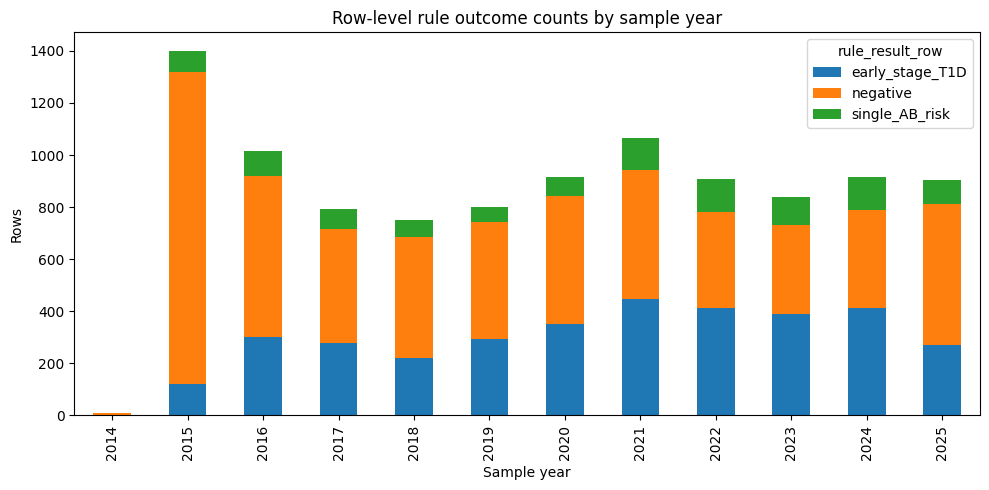

In [26]:
# Plot rule-based classification outcomes by year
plt.figure(figsize=(10, 5))

year_outcome = (
    df_explore
    .groupby(["sample_year", "rule_result_row"])
    .size()
    .unstack(fill_value=0)
)
year_outcome.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Row-level rule outcome counts by sample year")
plt.ylabel("Rows")
plt.xlabel("Sample year")
plt.tight_layout()
plt.show()


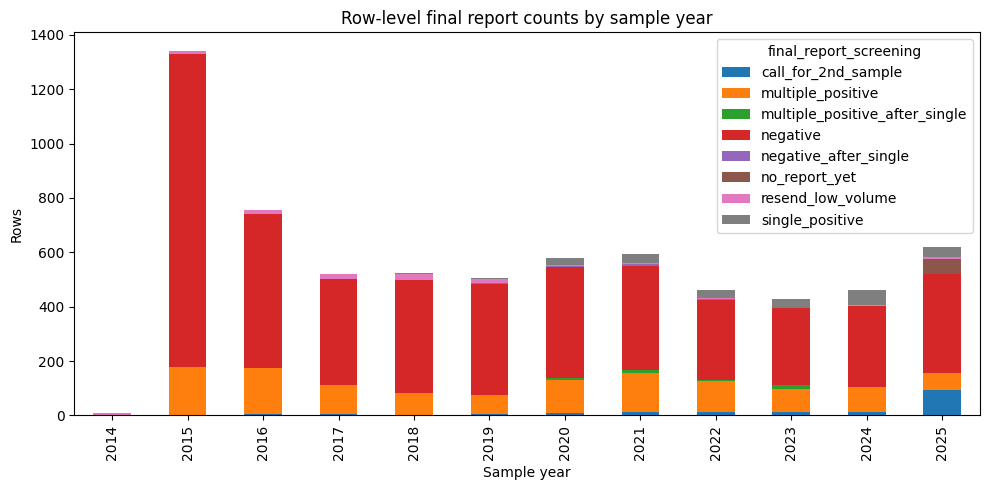

In [27]:
# Plot actual classification outcomes by year
plt.figure(figsize=(10, 5))

year_outcome = (
    df_explore
    .groupby(["sample_year", "final_report_screening"])
    .size()
    .unstack(fill_value=0)
)
year_outcome.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Row-level final report counts by sample year")
plt.ylabel("Rows")
plt.xlabel("Sample year")
plt.tight_layout()
plt.show()


In [28]:
# Count positivity rates by year for each antibody
positivity_cols = [
    "elisa_pos",
    "iaa_pos",
    "gada_trunc_pos",
    "ia2_pos",
    "znt8_pos",
]

positivity_by_year = (
    df_explore
    .groupby("sample_year")[positivity_cols]
    .mean()
)
print("Antibody positivity rates by sample year:")
display(positivity_by_year)



Antibody positivity rates by sample year:


,elisa_pos,iaa_pos,gada_trunc_pos,ia2_pos,znt8_pos
sample_year,,,,,
2014,0.000000,0.000000,0.000000,0.000000,0.000000
2015,0.550321,0.034261,0.179158,0.097787,0.132762
2016,0.553254,0.159763,0.429980,0.266272,0.329389
2017,0.511364,0.217172,0.433081,0.289141,0.324495
2018,0.537234,0.150266,0.385638,0.224734,0.277926
2019,0.408978,0.210723,0.422693,0.293017,0.310474
2020,0.385120,0.250547,0.461707,0.346827,0.341357
2021,0.355263,0.263158,0.521617,0.353383,0.416353
2022,0.289648,0.255507,0.551762,0.372247,0.438326


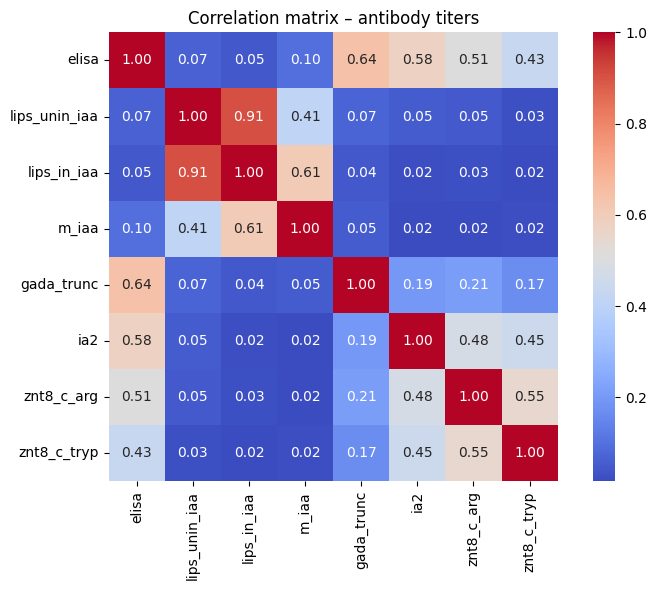

In [29]:
# Plot default (Pearson) correlation matrix of antibody titers
corr_cols = [
    "elisa",
    "lips_unin_iaa",
    "lips_in_iaa",
    "m_iaa",
    "gada_trunc",
    "ia2",
    "znt8_c_arg",
    "znt8_c_tryp",
]

corr_matrix = df_explore[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix – antibody titers")
plt.tight_layout()
plt.show()

# LIPS_unin_iaa ↔ LIPS_in_iaa: very strong (r≈0.9) -> redundant assays.
# LIPS_in_iaa ↔ m_iaa: moderate (r≈0.6) -> same antibody, different method.
# ELISA moderately correlates with GADA/IA2/ZnT8 (r≈0.5–0.6) -> good general screen.
# GADA, IA2, ZnT8 mostly independent (r<0.3) -> each adds unique info.
# ZnT8_arg ↔ ZnT8_tryp: moderate (r≈0.55) -> variants of same antigen.
# Overall: strong within-antibody method correlations, weak cross-antibody correlations -> good complementarity.


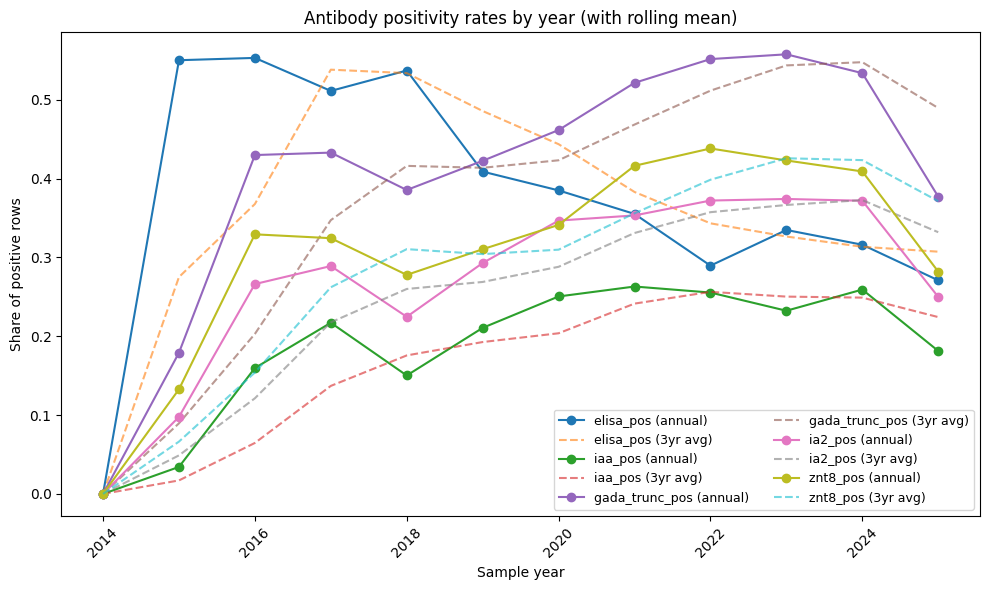

In [30]:
# Plot rolling positivity rates by year
rolling_window = 3
roll_means = (
    positivity_by_year
    .rolling(window=rolling_window, min_periods=1)
    .mean()
)

plt.figure(figsize=(10, 6))
for col in positivity_cols:
    plt.plot(
        positivity_by_year.index,
        positivity_by_year[col],
        marker="o",
        label=f"{col} (annual)"
    )
    plt.plot(
        roll_means.index,
        roll_means[col],
        linestyle="--",
        label=f"{col} ({rolling_window}yr avg)",
        alpha=0.6
    )
plt.title("Antibody positivity rates by year (with rolling mean)")
plt.ylabel("Share of positive rows")
plt.xlabel("Sample year")
plt.legend(ncol=2, fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. Dynamic Era-specific Modelling

In [31]:
# Compute era-specific (time-dependent) quantiles of antibody titers
# among ELISA-positive samples to detect assay drift and guide dynamic cutoff updates

# These quantiles can be used to derive dynamic, era-adjusted cutoffs
# so that positivity reflects the same percentile across time
era_bins = [2010, 2016, 2019, 2022, 2026]
era_labels = ["pre-2016", "2016-2018", "2019-2021", "2022+"]

df_threshold = df_rules.copy()
df_threshold["sample_year"] = df_threshold["sample_date"].dt.year

df_threshold["era"] = pd.cut(
    df_threshold["sample_year"],
    bins=era_bins,
    labels=era_labels,
    right=True,
)

quantile_targets = [0.95, 0.975, 0.99]
measure_cols = ["gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]

era_quantiles = (
    df_threshold.dropna(subset=[col for col in measure_cols])
    .groupby("era")[
        ["gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]
    ]
    .quantile(quantile_targets)
    .unstack(level=-1)
)

era_quantiles

# Gada and Ia2 : big rise after 2019, titers measured much higher in recent assays 
# -> possible method change/higher sensitivity
# MIaa: Gradual increase, then huge jump in 2022 -> new RIA or LIPS calibration
# Both ZnT8 variants show massive upward drift post-2019 -> new assay version with higher signal scale


/var/folders/lt/phtrlb2d77z3693qssqr9lzr0000gn/T/ipykernel_9105/2449537383.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_threshold.dropna(subset=[col for col in measure_cols])


gada_trunc                             ia2              \
                 0.950      0.975       0.990    0.950       0.975   
era                                                                  
pre-2016    844.400000  1135.8960  1495.00400  310.200  407.360000   
2016-2018   860.080000   988.1750  1117.17600  400.290  460.205000   
2019-2021  1247.110000  1375.5725  1609.61391  403.395  429.080104   
2022+      1576.965473  1799.3175  2037.27100  523.115  593.687500   

                        m_iaa                   znt8_c_arg             \
                0.990   0.950   0.975    0.990       0.950      0.975   
era                                                                     
pre-2016   555.788000  25.360  49.520   77.860  1430.12000  2083.3200   
2016-2018  539.646000  33.640  59.555  103.400  1792.10000  2387.0050   
2019-2021  480.028000  39.455  70.270  179.273  2271.40652  2848.4775   
2022+      742.494077  28.435  57.515  122.977  2955.06000  3337.2775   

                       znt8_c_tryp                          
                 0.990       0.950      0.975        0.990  
era                                                         
pre-2016   2718.744000    1571.740  2569.5000  4198.285476  
2016-2018  3205.882000    2579.850  3666.0230  4984.685666  
2019-2021  3163.634711    3313.205  4059.6400  4901.838000  
2022+      3789.826287    3755.700  4687.3525  5469.927103

In [32]:
# Compute quantile deltas vs baseline era
# This helps identify how much titers have shifted for each antibody
baseline_era = "2016-2018"

if baseline_era in era_quantiles.index:
    baseline = era_quantiles.loc[baseline_era]
    delta_from_baseline = era_quantiles.subtract(baseline)
    print(f"Quantile deltas vs baseline era '{baseline_era}':")
    display(delta_from_baseline)
else:
    print("Baseline era missing from quantile table.")


Quantile deltas vs baseline era '2016-2018':


gada_trunc                           ia2                          \
                0.950     0.975      0.990    0.950       0.975       0.990   
era                                                                           
pre-2016   -15.680000  147.7210  377.82800  -90.090  -52.845000   16.142000   
2016-2018    0.000000    0.0000    0.00000    0.000    0.000000    0.000000   
2019-2021  387.030000  387.3975  492.43791    3.105  -31.124896  -59.618000   
2022+      716.885473  811.1425  920.09500  122.825  133.482500  202.848077   

           m_iaa                  znt8_c_arg                        \
           0.950   0.975   0.990       0.950     0.975       0.990   
era                                                                  
pre-2016  -8.280 -10.035 -25.540  -361.98000 -303.6850 -487.138000   
2016-2018  0.000   0.000   0.000     0.00000    0.0000    0.000000   
2019-2021  5.815  10.715  75.873   479.30652  461.4725  -42.247289   
2022+     -5.205  -2.040  19.577  1162.96000  950.2725  583.944287   

          znt8_c_tryp                         
                0.950      0.975       0.990  
era                                           
pre-2016    -1008.110 -1096.5230 -786.400189  
2016-2018       0.000     0.0000    0.000000  
2019-2021     733.355   393.6170  -82.847666  
2022+        1175.850  1021.3295  485.241438

In [33]:
# These are 97.5th-percentile values of the raw RIA antibody distributions in each era 
# reflecting assay drift, not clinical cutoffs.
candidate_cutoffs = (
    era_quantiles.xs(0.975, level=1, axis=1)
    .reset_index()
    .rename_axis(None, axis=1)
)

print("97.5th percentile values by era (conditional on ELISA gate):")
display(candidate_cutoffs)

97.5th percentile values by era (conditional on ELISA gate):


,era,gada_trunc,ia2,m_iaa,znt8_c_arg,znt8_c_tryp
0,pre-2016,1135.8960,407.360000,49.520,2083.3200,2569.5000
1,2016-2018,988.1750,460.205000,59.555,2387.0050,3666.0230
2,2019-2021,1375.5725,429.080104,70.270,2848.4775,4059.6400
3,2022+,1799.3175,593.687500,57.515,3337.2775,4687.3525


In [34]:
# Build lookup table of 97.5th-percentile cutoffs per era
cutoff_table = candidate_cutoffs.set_index("era")

# Use baseline era cutoffs as fallback if sample era is missing
fallback_era = baseline_era if baseline_era in cutoff_table.index else cutoff_table.index[0]
fallback_row = cutoff_table.loc[fallback_era]

# Antibody measurements for which dynamic (era-specific) cutoffs apply
measure_cols = ["gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]

# Helper: get cutoff value for a given antibody and era
# -> falls back to baseline thresholds if era is unknown or NaN
def get_cutoff(era, col):
    if pd.isna(era) or era not in cutoff_table.index:
        return fallback_row[col]
    return cutoff_table.loc[era, col]

# Flag dynamic positivity per antibody using era-appropriate cutoff
for col in measure_cols:
    df_threshold[f"{col}_dyn_pos"] = df_threshold.apply(
        lambda row, c=col: bool(row[c] >= get_cutoff(row["era"], c)),
        axis=1,
    )

# Combine ZnT8 Arg and Tryp variants into a single ZnT8 dynamic flag
df_threshold["znt8_dyn_pos"] = (
    df_threshold["znt8_c_arg_dyn_pos"] | df_threshold["znt8_c_tryp_dyn_pos"]
)


In [35]:
# Count dynamically positive antibodies (GADA, IA-2, ZnT8) only if ELISA gate is positive
# We did this earlier but statically
# Now we test the idea of cutoff recalibration (per era) to correct for assay drift
ab_trio_dyn = np.where(
    df_threshold["elisa_pos"],
    df_threshold[["gada_trunc_dyn_pos", "ia2_dyn_pos", "znt8_dyn_pos"]].sum(axis=1),
    0,
)

# Add IAA positivity (kept static) to get total effective antibody count
# -> dynamic cutoffs apply only to RIA-based antibodies
df_threshold["effective_AB_positive_dyn"] = ab_trio_dyn + df_threshold["iaa_pos"].astype(int)

# Apply dynamic classification rules per row
# ≥2 positives -> early_stage_T1D
# exactly 1 (not ZnT8-only) -> single_AB_risk
# 0 -> negative
row_conditions_dyn = [
    df_threshold["effective_AB_positive_dyn"] >= 2,
    (df_threshold["effective_AB_positive_dyn"] == 1) & (~df_threshold["znt8_dyn_pos"]),
    df_threshold["effective_AB_positive_dyn"] == 0,
]
df_threshold["rule_result_row_dyn"] = np.select(
    row_conditions_dyn,
    ["early_stage_T1D", "single_AB_risk", "negative"],
    default="negative",
)

# Flag ZnT8-only single positives (dynamic scheme)
# -> ELISA gate true, exactly one antibody positive, and that one is ZnT8
row_single_only_znt8_dyn = (
    df_threshold["elisa_pos"]
    & (
        df_threshold[[
            "iaa_pos",
            "m_iaa_dyn_pos",
            "gada_trunc_dyn_pos",
            "ia2_dyn_pos",
            "znt8_dyn_pos",
        ]].sum(axis=1)
        == 1
    )
    & df_threshold["znt8_dyn_pos"]
)
df_threshold["row_single_only_znt8_dyn"] = row_single_only_znt8_dyn

In [36]:
# Dynamic vs original per-UID classes show stricter dynamic thresholds:
# Many original positives downgraded (early -> negative: 247; single -> negative: 489)
# No negatives upgraded (specificity goes up, sensitivity goes down)
# Early preserved in 177 UIDs, 129 early -> single

agg_dyn = (
    df_threshold
    .groupby("uid", as_index=False)
    .agg(
        max_effective_AB_positive_dyn=("effective_AB_positive_dyn", "max"),
        any_single_only_znt8_dyn=("row_single_only_znt8_dyn", "max"),
    )
)

uid_conditions_dyn = [
    agg_dyn["max_effective_AB_positive_dyn"] >= 2,
    (agg_dyn["max_effective_AB_positive_dyn"] == 1) & (~agg_dyn["any_single_only_znt8_dyn"]),
    agg_dyn["max_effective_AB_positive_dyn"] == 0,
]

agg_dyn["rule_result_uid_dyn"] = np.select(
    uid_conditions_dyn,
    ["early_stage_T1D", "single_AB_risk", "negative"],
    default="negative",
)

agg_compare = agg_rules.merge(
    agg_dyn[["uid", "rule_result_uid_dyn"]],
    on="uid",
    how="left",
)

display(
    pd.crosstab(
        agg_compare["rule_result_uid"],
        agg_compare["rule_result_uid_dyn"],
        rownames=["original"],
        colnames=["dynamic"],
    )
)


dynamic,early_stage_T1D,negative,single_AB_risk
original,,,
early_stage_T1D,13,258,454
negative,0,3742,0
single_AB_risk,0,429,69


In [37]:
# Compare dynamic-rule classifications against true clinical labels
eval_dyn = agg_dyn.merge(labels_uid, on="uid", how="left")

display(
    pd.crosstab(
        eval_dyn["rule_result_uid_dyn"],
        eval_dyn["label_early_stage"],
        rownames=["dynamic_rule"],
        colnames=["early_stage_T1D"],
    )
)

# Dynamic thresholds sharply reduce the number of positives (both early-stage and single).
# 248 early-stage and 424 single-positive cases become negative.
# No negatives are ever upgraded → specificity ↑.
# Sensitivity ↓ — only 33 true early cases remain classified as early_stage_T1D.
# Most true early cases shift to single_positive or negative.

early_stage_T1D,0,1
dynamic_rule,,
early_stage_T1D,0,13
negative,4201,228
single_AB_risk,95,428


In [38]:
# UIDs whose classification changed between static (rule_result_uid) and dynamic (rule_result_uid_dyn) rules
# Dynamic thresholds are stricter, producing fewer positives.
flipped = agg_compare[agg_compare["rule_result_uid"] != agg_compare["rule_result_uid_dyn"]]
print(f"UIDs with classification change: {flipped.shape[0]}")

display(
    flipped["rule_result_uid"].value_counts().rename("original"),
)
print("\nOriginal -> Dynamic transitions:")
display(
    flipped.groupby(["rule_result_uid", "rule_result_uid_dyn"]).size().to_frame("count")
)

UIDs with classification change: 1141


rule_result_uid
early_stage_T1D    712
single_AB_risk     429
Name: original, dtype: int64


Original -> Dynamic transitions:


count
rule_result_uid rule_result_uid_dyn       
early_stage_T1D negative               258
                single_AB_risk         454
single_AB_risk  negative               429

In [39]:
flip_details = df_threshold[df_threshold["uid"].isin(flipped["uid"])]
flip_details = flip_details.sort_values(["uid", "sample_date", "source"])

print("Example rows for flipped UIDs:")
display(
    flip_details[[
        "uid",
        "era",
        "sample_date",
        "source",
        "elisa",
        "elisa_pos",
        "gada_trunc",
        "gada_trunc_pos",
        "gada_trunc_dyn_pos",
        "ia2",
        "ia2_pos",
        "ia2_dyn_pos",
        "znt8_c_arg",
        "znt8_c_arg_pos",
        "znt8_c_arg_dyn_pos",
        "znt8_c_tryp",
        "znt8_c_tryp_pos",
        "znt8_c_tryp_dyn_pos",
        "effective_AB_positive",
        "effective_AB_positive_dyn",
        "rule_result_row",
        "rule_result_row_dyn",
        "final_report_screening",
    ]].head(20)
)



Example rows for flipped UIDs:


,uid,era,sample_date,source,elisa,elisa_pos,gada_trunc,gada_trunc_pos,gada_trunc_dyn_pos,ia2,ia2_pos,ia2_dyn_pos,znt8_c_arg,znt8_c_arg_pos,znt8_c_arg_dyn_pos,znt8_c_tryp,znt8_c_tryp_pos,znt8_c_tryp_dyn_pos,effective_AB_positive,effective_AB_positive_dyn,rule_result_row,rule_result_row_dyn,final_report_screening
8,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2015-10-16,screening,132.480000,True,62.100000,True,False,0.100000,False,False,27.800000,True,False,116.700000,True,False,2,0,early_stage_T1D,negative,multiple_positive
9,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2015-12-16,screening,NaN,False,64.300000,True,False,0.100000,False,False,106.500000,True,False,345.700000,True,False,0,0,negative,negative,multiple_positive
10,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2016-02-18,follow_up,NaN,False,293.600000,True,False,0.100000,False,False,181.600000,True,False,388.500000,True,False,3,1,early_stage_T1D,single_AB_risk,NaN
11,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2016-04-11,follow_up,NaN,False,200.300000,True,False,0.100000,False,False,157.100000,True,False,330.100000,True,False,3,1,early_stage_T1D,single_AB_risk,NaN
12,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2016-07-05,follow_up,NaN,False,563.540000,True,False,0.100000,False,False,725.760000,True,False,1158.260000,True,False,3,1,early_stage_T1D,single_AB_risk,NaN
13,00853647-9F13-4037-9980-8F4EEC54AF98,pre-2016,2016-10-04,follow_up,NaN,False,719.610000,True,False,0.100000,False,False,656.580000,True,False,1082.230000,True,False,3,1,early_stage_T1D,single_AB_risk,NaN
14,00853647-9F13-4037-9980-8F4EEC54AF98,2016-2018,2017-01-03,follow_up,NaN,False,538.990000,True,False,0.100000,False,False,244.750000,True,False,451.200000,True,False,3,1,early_stage_T1D,single_AB_risk,NaN
15,00853647-9F13-4037-9980-8F4EEC54AF98,2016-2018,2017-04-19,follow_up,NaN,False,338.800000,True,False,0.100000,False,False,30.200000,True,False,65.700000,True,False,3,1,early_stage_T1D,single_AB_risk,NaN
16,00853647-9F13-4037-9980-8F4EEC54AF98,2016-2018,2017-10-25,follow_up,NaN,False,474.600000,True,False,0.100000,False,False,41.200000,True,False,69.000000,True,False,3,1,early_stage_T1D,single_AB_risk,NaN
17,00853647-9F13-4037-9980-8F4EEC54AF98,2016-2018,2019-04-16,follow_up,NaN,False,387.200000,True,False,0.300000,False,False,334.700000,True,False,344.300000,True,False,3,1,early_stage_T1D,single_AB_risk,NaN


In [40]:
# Evaluate flipped uids
flipped_eval = flipped.merge(labels_uid, on="uid", how="left")

print("Label distribution among flipped UIDs:")
display(
    flipped_eval.groupby(["rule_result_uid", "rule_result_uid_dyn", "label_early_stage"]).size().to_frame("count")
)



Label distribution among flipped UIDs:


count
rule_result_uid rule_result_uid_dyn label_early_stage       
early_stage_T1D negative            0                     82
                                    1                    176
                single_AB_risk      0                     34
                                    1                    420
single_AB_risk  negative            0                    396
                                    1                     33

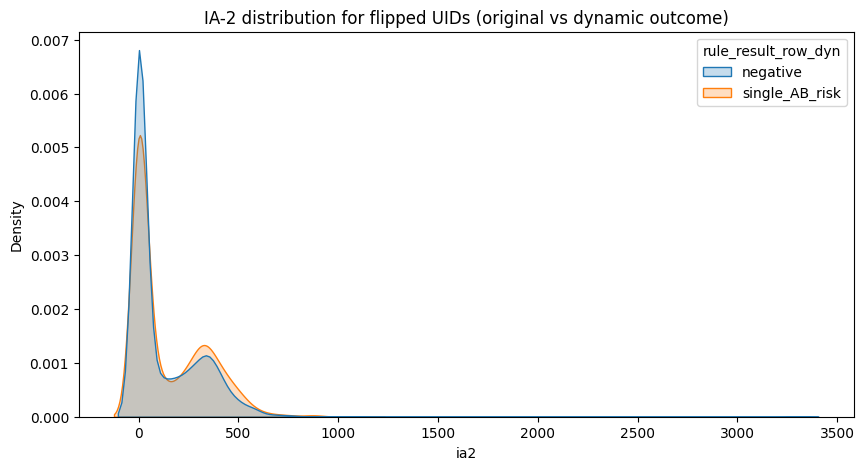

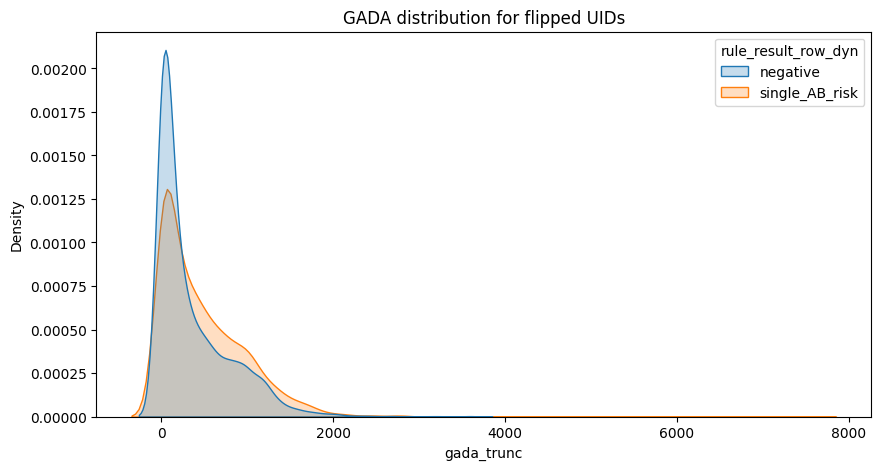

In [41]:
# KDEs for IA-2/GADA on flipped UIDs:
# 'single_AB_risk' curves are shifted to higher titers than 'negative'
# but with substantial overlap → stricter dynamic cutoffs sit in the overlap region
# Borderline IA-2/GADA values are main drivers of downgrades (source of new FNs)
 
plt.figure(figsize=(10, 5))
sns.kdeplot(data=flip_details, x="ia2", hue="rule_result_row_dyn", fill=True, common_norm=False)
plt.title("IA-2 distribution for flipped UIDs (original vs dynamic outcome)")
plt.show()

plt.figure(figsize=(10, 5))
sns.kdeplot(data=flip_details, x="gada_trunc", hue="rule_result_row_dyn", fill=True, common_norm=False)
plt.title("GADA distribution for flipped UIDs")
plt.show()



### 5. Simple Modelling: Linear Regression and Gradient Boost

In [42]:
# Create one row per uid, aggregating values from 90 days after first screening
# Keep strongest AB values

# Use only the first N days from each child's first sample (screening-time window)
MODEL_WINDOW_DAYS = 120

# Start from df_threshold, which already has both static and dynamic flags/counts
mod_base = df_threshold.copy()

# Find each UID's first sample date
first_screen_date = (
    mod_base.groupby("uid")["sample_date"].min().rename("first_date")
)

# Keep rows within [first_date, first_date + 90 days]
model_window = (
    mod_base
    .merge(first_screen_date, on="uid", how="left")
    .loc[lambda d: d["sample_date"] <= d["first_date"] + pd.to_timedelta(MODEL_WINDOW_DAYS, unit="D")]
)

# Aggregate to one feature row per UID (summarize the 90-day episode)
agg_features = model_window.groupby("uid").agg({
    # Max titers within the window (strongest signal)
    "elisa": "max",
    "gada_trunc": "max",
    "ia2": "max",
    "m_iaa": "max",
    "znt8_c_arg": "max",
    "znt8_c_tryp": "max",

    # Demographic/prior: youngest age at sample; any FDR ever in window
    "age_at_sample": "min",
    "any_fdr": "max",

    # Ever ELISA gate positive within the window
    "elisa_pos": "max",

    # Max number of positive antibodies (static vs dynamic rules) in the window
    "effective_AB_positive": "max",
    "effective_AB_positive_dyn": "max",

    # Ever ZnT8-only single (static vs dynamic) in the window
    "row_single_only_znt8": "max",
    "row_single_only_znt8_dyn": "max",

    # Did any row in the window classify as early_stage_T1D? (static vs dynamic)
    "rule_result_row":      lambda s: (s == "early_stage_T1D").any(),
    "rule_result_row_dyn":  lambda s: (s == "early_stage_T1D").any(),
})

# Make those boolean "any early" columns explicit
agg_features = agg_features.rename(columns={
    "rule_result_row": "any_row_early",
    "rule_result_row_dyn": "any_row_early_dyn",
})

# Add cohort meta (follow-up presence, span_days, n_rows) and the ground-truth label
uid_features = (
    agg_features
    .merge(uid_summary[["any_follow_up", "span_days", "n_rows"]],
           left_index=True, right_index=True, how="left")
    .merge(labels_uid.set_index("uid"),
           left_index=True, right_index=True, how="left")
    .fillna({"label_early_stage": 0})  # default missing labels to 0 (conservative)
)

print(f"Modeling dataset: {uid_features.shape[0]} UIDs × {uid_features.shape[1]} features")

uid_features.head()

Modeling dataset: 4965 UIDs × 19 features


,elisa,gada_trunc,ia2,m_iaa,znt8_c_arg,znt8_c_tryp,age_at_sample,any_fdr,elisa_pos,effective_AB_positive,effective_AB_positive_dyn,row_single_only_znt8,row_single_only_znt8_dyn,any_row_early,any_row_early_dyn,any_follow_up,span_days,n_rows,label_early_stage
uid,,,,,,,,,,,,,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,132.320000,8.5,0.1,1.0,0.1,0.1,3.78,0,True,0,0,False,False,False,False,False,0,1,0
0033DB11-56A2-4E3D-9B8F-0556819CF005,1.335415,0.1,0.1,14.7,0.1,0.1,3.10,0,False,0,0,False,False,False,False,True,416,3,0
005B2E43-F96E-406F-AB19-BECB1692A4C6,26.920000,0.1,0.1,0.7,0.1,0.1,3.92,0,True,0,0,False,False,False,False,False,0,1,0
00612B9E-AB0E-4E25-9078-219711028F73,54.409000,3.8,0.1,0.6,0.1,0.1,2.16,0,True,0,0,False,False,False,False,True,2341,2,0
00731613-E23A-4DA4-849F-9D1762C9E3D7,130.640000,0.1,0.1,NaN,0.1,0.1,5.25,0,True,0,0,False,False,False,False,False,0,1,0


In [43]:
# Calculates the fraction of missing values per column
uid_features.isna().mean().sort_values(ascending=False).head(10)


m_iaa            0.389527
znt8_c_tryp      0.098087
gada_trunc       0.096073
znt8_c_arg       0.072508
ia2              0.053575
age_at_sample    0.001208
elisa            0.000806
any_row_early    0.000000
n_rows           0.000000
span_days        0.000000
dtype: float64

In [44]:
# Select input features for modeling (antibodies, demographics, derived rule features)
feature_cols = [
    "elisa", "gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp",
    "age_at_sample", "any_fdr", "elisa_pos",
    "effective_AB_positive", "effective_AB_positive_dyn",
    "row_single_only_znt8", "row_single_only_znt8_dyn",
    "any_follow_up", "span_days", "n_rows",
    "any_row_early", "any_row_early_dyn",
]

# Using only biomarkers to prevent cheating and bias
clean_feature_cols = [
    "elisa", "gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp",
    "age_at_sample", "any_fdr",
]

# Build modeling dataframe (features + label)
model_df = uid_features[feature_cols + ["label_early_stage"]].copy()

# Impute missing values and create missingness indicator columns
for col in feature_cols:
    model_df[col + "_missing"] = model_df[col].isna().astype(int)   # binary missing flag
    model_df[col] = model_df[col].fillna(model_df[col].median())    # median imputation

model_df.head()

,elisa,gada_trunc,ia2,m_iaa,znt8_c_arg,znt8_c_tryp,age_at_sample,any_fdr,elisa_pos,effective_AB_positive,effective_AB_positive_dyn,row_single_only_znt8,row_single_only_znt8_dyn,any_follow_up,span_days,n_rows,any_row_early,any_row_early_dyn,label_early_stage,elisa_missing,gada_trunc_missing,ia2_missing,m_iaa_missing,znt8_c_arg_missing,znt8_c_tryp_missing,age_at_sample_missing,any_fdr_missing,elisa_pos_missing,effective_AB_positive_missing,effective_AB_positive_dyn_missing,row_single_only_znt8_missing,row_single_only_znt8_dyn_missing,any_follow_up_missing,span_days_missing,n_rows_missing,any_row_early_missing,any_row_early_dyn_missing
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,132.320000,8.5,0.1,1.0,0.1,0.1,3.78,0,True,0,0,False,False,False,0,1,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0033DB11-56A2-4E3D-9B8F-0556819CF005,1.335415,0.1,0.1,14.7,0.1,0.1,3.10,0,False,0,0,False,False,True,416,3,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
005B2E43-F96E-406F-AB19-BECB1692A4C6,26.920000,0.1,0.1,0.7,0.1,0.1,3.92,0,True,0,0,False,False,False,0,1,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00612B9E-AB0E-4E25-9078-219711028F73,54.409000,3.8,0.1,0.6,0.1,0.1,2.16,0,True,0,0,False,False,True,2341,2,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00731613-E23A-4DA4-849F-9D1762C9E3D7,130.640000,0.1,0.1,1.0,0.1,0.1,5.25,0,True,0,0,False,False,False,0,1,False,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# Split features and target label
X = model_df.drop(columns=["label_early_stage"]).values
y = model_df["label_early_stage"].astype(int).values

# Scale only continuous features (exclude binary missing flags)
n_base = len(feature_cols)
X_cont = X[:, :n_base]
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(X_cont)
X_final = np.hstack([X_cont_scaled, X[:, n_base:]])

# Train/test split (preserve label balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

# Logistic Regression baseline (linear, interpretable)
lr = LogisticRegression(max_iter=2000, class_weight="balanced")
lr.fit(X_train, y_train)

y_proba_lr = lr.predict_proba(X_test)[:, 1]
print("Logistic Regression Metrics:")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_lr):.3f}")
print(f"PR AUC: {average_precision_score(y_test, y_proba_lr):.3f}")
print(classification_report(y_test, (y_proba_lr >= 0.5).astype(int)))

gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train)

y_proba_gbm = gbm.predict_proba(X_test)[:, 1]
print("\nGradient Boosting Metrics:")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_gbm):.3f}")
print(f"PR AUC: {average_precision_score(y_test, y_proba_gbm):.3f}")
print(classification_report(y_test, (y_proba_gbm >= 0.5).astype(int)))

# ROC AUC / PR AUC show overall discrimination and precision-recall tradeoff
# -> excellent results: AUC ≈ 0.98, accuracy ≈ 96%
# -> slight numeric warnings due to extreme feature scales or constants

# Gradient Boosting (nonlinear, ensemble-based)
# Captures complex interactions between antibodies
# -> even stronger performance (AUC ≈ 0.99, accuracy ≈ 98%)

Logistic Regression Metrics:
ROC AUC: 0.979
PR AUC: 0.939
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1075
           1       0.81      0.90      0.86       167

    accuracy                           0.96      1242
   macro avg       0.90      0.94      0.92      1242
weighted avg       0.96      0.96      0.96      1242


Gradient Boosting Metrics:
ROC AUC: 0.984
PR AUC: 0.953
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1075
           1       0.95      0.86      0.90       167

    accuracy                           0.98      1242
   macro avg       0.97      0.92      0.94      1242
weighted avg       0.97      0.98      0.97      1242



In [46]:
# Each coefficient shows how strongly that feature affects the prediction
# Positive -> increases the chance of early-stage T1D
# Negative -> decreases the chance

coef = pd.Series(lr.coef_[0], index=model_df.drop(columns=["label_early_stage"]).columns)
print("Top logistic coefficients:")
display(coef.sort_values(key=np.abs, ascending=False).head(10))

feature_importance = pd.Series(gbm.feature_importances_, index=model_df.drop(columns=["label_early_stage"]).columns)
print("\nGradient Boosting feature importances:")
display(feature_importance.sort_values(ascending=False).head(10))

# --- Feature Importance Analysis ---

# Logistic Regression:
# -> Coefficients show direction (+/-) and strength of effect on T1D risk
# -> Positive = increases probability of early-stage T1D
# Key findings:
# 1. n_rows: Strongest predictor (more samples/follow-ups -> higher T1D likelihood)
# 2. effective_AB_positive, elisa, ia2: True biological markers of risk
# 3. Several *_missing flags also predictive (reflect data collection patterns, not biology)
# -> Model learns expected relationships between antibody levels and T1D risk

# Gradient Boosting:
# -> Feature importances show contribution to reducing prediction error
# Key findings:
# 1. n_rows and elisa dominate (frequent sampling and strong ELISA signals → higher risk)
# 2. effective_AB_positive, ia2, m_iaa also important contributors
# 3. span_days (duration of follow-up) carries moderate predictive value
# -> Confirms antibody patterns are most predictive, but follow-up structure also informative


Top logistic coefficients:


n_rows                   3.363548
effective_AB_positive    1.140753
m_iaa_missing           -0.996084
ia2_missing              0.762171
elisa                    0.563978
znt8_c_tryp_missing     -0.541232
znt8_c_tryp              0.465542
ia2                      0.451642
gada_trunc_missing       0.383732
span_days               -0.342418
dtype: float64


Gradient Boosting feature importances:


n_rows                   0.323449
any_row_early            0.213632
effective_AB_positive    0.186729
elisa                    0.077299
ia2                      0.053068
m_iaa                    0.052379
span_days                0.023271
znt8_c_tryp              0.017761
gada_trunc               0.016288
any_follow_up            0.013286
dtype: float64

In [47]:
clean_df = uid_features[clean_feature_cols + ["label_early_stage"]].copy()

# Missingness indicators + imputation
for col in clean_feature_cols:
    clean_df[col + "_missing"] = clean_df[col].isna().astype(int)
    clean_df[col] = clean_df[col].fillna(clean_df[col].median())

X_clean = clean_df.drop(columns=["label_early_stage"]).values
y_clean = clean_df["label_early_stage"].astype(int).values

# Scale continuous part
n_clean = len(clean_feature_cols)
X_clean_cont = X_clean[:, :n_clean]
clean_scaler = StandardScaler()
X_clean_cont_scaled = clean_scaler.fit_transform(X_clean_cont)
X_clean_final = np.hstack([X_clean_cont_scaled, X_clean[:, n_clean:]])

# Split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clean_final,
    y_clean,
    test_size=0.25,
    stratify=y_clean,
    random_state=42,
)

# Logistic model (clean)
lr_clean = LogisticRegression(max_iter=2000, class_weight="balanced")
lr_clean.fit(Xc_train, yc_train)

yc_proba_lr = lr_clean.predict_proba(Xc_test)[:, 1]
print("\n\n=== CLEAN LOGISTIC MODEL (biomarker-only) ===")
print(f"ROC AUC: {roc_auc_score(yc_test, yc_proba_lr):.3f}")
print(f"PR AUC: {average_precision_score(yc_test, yc_proba_lr):.3f}")
print(classification_report(yc_test, (yc_proba_lr >= 0.5).astype(int)))

clean_coef = pd.Series(lr_clean.coef_[0], index=clean_df.drop(columns=["label_early_stage"]).columns)
print("\nClean logistic coefficients (pure cutoff discovery):")
display(clean_coef.sort_values(key=np.abs, ascending=False).head(10))



=== CLEAN LOGISTIC MODEL (biomarker-only) ===
ROC AUC: 0.956
PR AUC: 0.871
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1075
           1       0.75      0.81      0.78       167

    accuracy                           0.94      1242
   macro avg       0.86      0.89      0.87      1242
weighted avg       0.94      0.94      0.94      1242


Clean logistic coefficients (pure cutoff discovery):


ia2_missing              2.124155
m_iaa_missing           -1.526775
ia2                      1.267360
elisa_missing            1.025413
elisa                    1.020149
znt8_c_arg               0.991410
gada_trunc               0.830829
znt8_c_arg_missing      -0.511240
m_iaa                    0.412825
age_at_sample_missing   -0.348386
dtype: float64

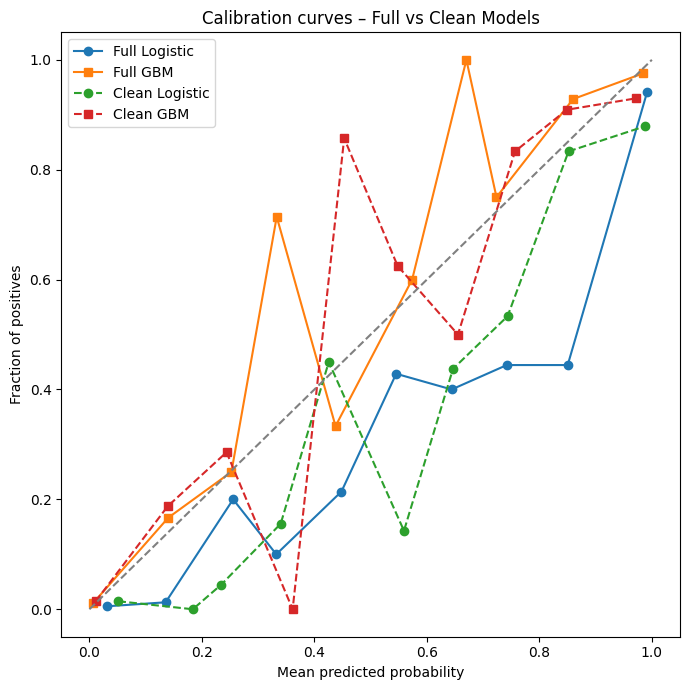

In [48]:
prob_true_lr,  prob_pred_lr  = calibration_curve(y_test, y_proba_lr,  n_bins=10)
prob_true_gbm, prob_pred_gbm = calibration_curve(y_test, y_proba_gbm, n_bins=10)

# Clean biomarker-only model probabilities

# Predict with clean logistic model
yc_proba_lr_test = lr_clean.predict_proba(Xc_test)[:, 1]

# To get GBM version, we train a clean GBM model too:
gbm_clean = GradientBoostingClassifier(random_state=42)
gbm_clean.fit(Xc_train, yc_train)
yc_proba_gbm_test = gbm_clean.predict_proba(Xc_test)[:, 1]

prob_true_lr_clean,  prob_pred_lr_clean  = calibration_curve(yc_test, yc_proba_lr_test,  n_bins=10)
prob_true_gbm_clean, prob_pred_gbm_clean = calibration_curve(yc_test, yc_proba_gbm_test, n_bins=10)

#  Plot: full model + clean model calibration curves

plt.figure(figsize=(7, 7))

# Full model curves
plt.plot(prob_pred_lr,  prob_true_lr,  marker="o", label="Full Logistic")
plt.plot(prob_pred_gbm, prob_true_gbm, marker="s", label="Full GBM")

# Clean model curves
plt.plot(prob_pred_lr_clean,  prob_true_lr_clean,  marker="o", linestyle="--", label="Clean Logistic")
plt.plot(prob_pred_gbm_clean, prob_true_gbm_clean, marker="s", linestyle="--", label="Clean GBM")

# Perfect calibration line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves – Full vs Clean Models")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
full_cutoff_df = model_df.copy()  # full feature table INCLUDING derived features

# Use ALL features except the target label
all_features = [col for col in full_cutoff_df.columns if col != "label_early_stage"]

full_results = []

for feat in all_features:
    values = full_cutoff_df[feat].values
    labels = full_cutoff_df["label_early_stage"].values

    # Remove rows where feature is missing
    mask = ~np.isnan(values)
    v = values[mask]
    y = labels[mask]

    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y, v)

    # Compute Youden's J statistic
    J = tpr - fpr
    best_idx = np.argmax(J)

    full_results.append({
        "feature": feat,
        "threshold_optimal": thresholds[best_idx],
        "sensitivity": tpr[best_idx],
        "specificity": 1 - fpr[best_idx],
        "youden_J": J[best_idx],
        "AUC": roc_auc_score(y, v),
        "n": len(v)
    })

full_cutoff_table = pd.DataFrame(full_results)

# Sort by AUC (best predictors at top)
full_cutoff_table = full_cutoff_table.sort_values("AUC", ascending=False)

full_cutoff_table

,feature,threshold_optimal,sensitivity,specificity,youden_J,AUC,n
15,n_rows,3.000000,0.760837,0.955307,0.716144,0.931232,4965
9,effective_AB_positive,1.000000,0.905830,0.863827,0.769656,0.926928,4965
0,elisa,267.705174,0.852018,0.911778,0.763796,0.913671,4965
1,gada_trunc,16.200000,0.849028,0.876164,0.725192,0.904592,4965
16,any_row_early,1.000000,0.717489,0.980214,0.697703,0.848851,4965
14,span_days,2.000000,0.940209,0.754190,0.694399,0.847925,4965
13,any_follow_up,1.000000,0.753363,0.924348,0.677711,0.838856,4965
2,ia2,0.200000,0.702541,0.943203,0.645744,0.835347,4965
3,m_iaa,2.200000,0.704036,0.877561,0.581596,0.828482,4965
4,znt8_c_arg,8.300000,0.605381,0.951816,0.557197,0.797961,4965


In [50]:
# Only use the clean biomarker feature table
cutoff_df = clean_df.copy()

antibodies = ["elisa", "gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]

results = []

for ab in antibodies:
    values = cutoff_df[ab].values
    labels = cutoff_df["label_early_stage"].values

    # Remove rows where antibody value is missing
    mask = ~np.isnan(values)
    v = values[mask]
    y = labels[mask]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, v)

    # Compute Youden's J index
    J = tpr - fpr
    best_idx = np.argmax(J)

    best_threshold = thresholds[best_idx]
    best_sens = tpr[best_idx]
    best_spec = 1 - fpr[best_idx]
    auc = roc_auc_score(y, v)

    results.append({
        "antibody": ab,
        "threshold_optimal": best_threshold,
        "sensitivity": best_sens,
        "specificity": best_spec,
        "youden_J": J[best_idx],
        "AUC": auc,
        "n": len(v)
    })

cutoff_table = pd.DataFrame(results)
cutoff_table

,antibody,threshold_optimal,sensitivity,specificity,youden_J,AUC,n
0,elisa,267.705174,0.852018,0.911778,0.763796,0.913671,4965
1,gada_trunc,16.200000,0.849028,0.876164,0.725192,0.904592,4965
2,ia2,0.200000,0.702541,0.943203,0.645744,0.835347,4965
3,m_iaa,2.200000,0.704036,0.877561,0.581596,0.828482,4965
4,znt8_c_arg,8.300000,0.605381,0.951816,0.557197,0.797961,4965
5,znt8_c_tryp,2.400000,0.559043,0.930633,0.489676,0.759361,4965


In [51]:
# A UID is single_positive if at any time they got final_report_screening == 'single_positive'
labels_single_uid = (
    df_rules
    .assign(label_single=lambda d: (d["final_report_screening"] == "single_positive").astype(int))
    .groupby("uid", as_index=False)["label_single"]
    .max()
)

# Merge into uid_features and clean_df
uid_features = (
    uid_features
    .merge(labels_single_uid.set_index("uid"), left_index=True, right_index=True, how="left")
    .fillna({"label_single": 0})
)

clean_df = (
    clean_df
    .drop(columns=[c for c in ["label_single"] if c in clean_df.columns])
    .merge(
        uid_features[["label_single"]],
        left_index=True,
        right_index=True,
        how="left"
    )
    .fillna({"label_single": 0})
)

# 0.2 Attach a dominant era per UID (era of first sample)
era_per_uid = (
    df_threshold
    .sort_values(["uid", "sample_date"])
    .groupby("uid")["era"]
    .first()
    .rename("era_uid")
)

clean_df = (
    clean_df
    .drop(columns=[c for c in ["era_uid"] if c in clean_df.columns])
    .merge(era_per_uid, left_index=True, right_index=True, how="left")
)

In [52]:
# 1. High-specificity ROC-based thresholds for early-stage T1D (global)

def high_specificity_cutoff(values, labels, specificity_target=0.995):
    """Return (threshold, sensitivity, specificity, auc) at or above a given specificity."""
    mask = ~np.isnan(values)
    v = values[mask]
    y = labels[mask]
    if len(np.unique(y)) < 2:
        return np.nan, np.nan, np.nan, np.nan

    fpr, tpr, thresholds = roc_curve(y, v)
    spec = 1 - fpr
    auc = roc_auc_score(y, v)

    # indices where specificity >= target
    idx = np.where(spec >= specificity_target)[0]
    if len(idx) == 0:
        # fallback: best Youden index
        J = tpr - fpr
        best = np.argmax(J)
    else:
        # among these, choose highest sensitivity
        best = idx[np.argmax(tpr[idx])]

    return thresholds[best], tpr[best], spec[best], auc

early_labels = clean_df["label_early_stage"].values
specificity_target = 0.995  # 99.5% specificity, adjust if desired

global_results = []
for ab in ["elisa", "gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]:
    vals = clean_df[ab].values
    thr, sens, spec, auc = high_specificity_cutoff(vals, early_labels, specificity_target)
    global_results.append({
        "antibody": ab,
        "threshold_highspec": thr,
        "sensitivity": sens,
        "specificity": spec,
        "AUC": auc,
        "n": np.sum(~np.isnan(vals))
    })

cutoffs_highspec_global = pd.DataFrame(global_results)
print("High-specificity (early-stage) cutoffs (global):")
display(cutoffs_highspec_global)

High-specificity (early-stage) cutoffs (global):


,antibody,threshold_highspec,sensitivity,specificity,AUC,n
0,elisa,3900.0,0.254111,0.995112,0.913671,4965
1,gada_trunc,1182.4,0.115097,0.995112,0.904592,4965
2,ia2,156.9,0.369208,0.995112,0.835347,4965
3,m_iaa,43.7,0.103139,0.995112,0.828482,4965
4,znt8_c_arg,733.5,0.292975,0.995345,0.797961,4965
5,znt8_c_tryp,563.2,0.322870,0.995112,0.759361,4965


In [53]:
# 2. Per-era high-specificity cutoffs for early-stage T1D

era_results = []

for era_val, sub in clean_df.groupby("era_uid"):
    if pd.isna(era_val):
        continue
    labels_e = sub["label_early_stage"].values
    if len(np.unique(labels_e)) < 2:
        continue

    for ab in ["gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]:
        vals = sub[ab].values
        thr, sens, spec, auc = high_specificity_cutoff(vals, labels_e, specificity_target)
        era_results.append({
            "era_uid": era_val,
            "antibody": ab,
            "threshold_highspec": thr,
            "sensitivity": sens,
            "specificity": spec,
            "AUC": auc,
            "n": np.sum(~np.isnan(vals))
        })

cutoffs_highspec_era = pd.DataFrame(era_results)
print("Per-era high-specificity cutoffs (early-stage):")
display(cutoffs_highspec_era.sort_values(["antibody", "era_uid"]))

Per-era high-specificity cutoffs (early-stage):


/var/folders/lt/phtrlb2d77z3693qssqr9lzr0000gn/T/ipykernel_9105/4026084832.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for era_val, sub in clean_df.groupby("era_uid"):


,era_uid,antibody,threshold_highspec,sensitivity,specificity,AUC,n
5,2016-2018,gada_trunc,662.8,0.186667,0.995556,0.905644,1275
10,2019-2021,gada_trunc,1224.8,0.111650,0.995408,0.901976,1077
15,2022+,gada_trunc,1611.7,0.072727,0.995434,0.878719,767
0,pre-2016,gada_trunc,658.7,0.344828,0.995131,0.911048,1846
6,2016-2018,ia2,24.6,0.426667,0.995556,0.830767,1275
11,2019-2021,ia2,149.6,0.388350,0.995408,0.847246,1077
16,2022+,ia2,438.7,0.236364,0.995434,0.857472,767
1,pre-2016,ia2,15.7,0.517241,0.995131,0.812664,1846
7,2016-2018,m_iaa,33.4,0.153333,0.995556,0.852030,1275
12,2019-2021,m_iaa,94.0,0.029126,0.997704,0.802955,1077


In [54]:
# 3. High-specificity cutoffs for single-positive at-risk
single_labels = clean_df["label_single"].values

# Restrict to UIDs that are not early-stage (to focus on single vs true negatives)
mask_not_early = clean_df["label_early_stage"] == 0
single_labels_ne = single_labels[mask_not_early]

single_results = []
for ab in ["elisa", "gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]:
    vals = clean_df.loc[mask_not_early, ab].values
    thr, sens, spec, auc = high_specificity_cutoff(vals, single_labels_ne, specificity_target)
    single_results.append({
        "antibody": ab,
        "threshold_highspec_single": thr,
        "sensitivity": sens,
        "specificity": spec,
        "AUC": auc,
        "n": np.sum(~np.isnan(vals))
    })

cutoffs_highspec_single = pd.DataFrame(single_results)
print("High-specificity cutoffs for single-positive vs true negatives:")
display(cutoffs_highspec_single)

High-specificity cutoffs for single-positive vs true negatives:


,antibody,threshold_highspec_single,sensitivity,specificity,AUC,n
0,elisa,3253.180484,0.036697,0.995223,0.649293,4296
1,gada_trunc,1028.400000,0.110092,0.995223,0.788281,4296
2,ia2,169.300000,0.018349,0.995701,0.547351,4296
3,m_iaa,41.300000,0.119266,0.997373,0.542589,4296
4,znt8_c_arg,inf,0.000000,1.000000,0.495873,4296
5,znt8_c_tryp,inf,0.000000,1.000000,0.502215,4296


In [55]:
# 4. Interpretable decision tree for early-stage detection
tree_features = ["elisa", "gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp",
                 "age_at_sample", "any_fdr"]
tree_df = clean_df[tree_features + ["label_early_stage"]].copy()

# Simple imputation (median)
for col in tree_features:
    tree_df[col] = tree_df[col].fillna(tree_df[col].median())

X_tree = tree_df[tree_features].values
y_tree = tree_df["label_early_stage"].astype(int).values

Xtr_train, Xtr_test, ytr_train, ytr_test = train_test_split(
    X_tree, y_tree, test_size=0.25, stratify=y_tree, random_state=42
)

dt = DecisionTreeClassifier(
    max_depth=3,            # keep tree shallow for interpretability
    min_samples_leaf=50,    # avoid overfitting tiny leaves
    class_weight="balanced",
    random_state=42,
)
dt.fit(Xtr_train, ytr_train)

ytr_proba = dt.predict_proba(Xtr_test)[:, 1]
print("Decision tree ROC AUC:", roc_auc_score(ytr_test, ytr_proba))

tree_rules = export_text(dt, feature_names=tree_features, decimals=2)
print("\nDecision tree rules:\n")
print(tree_rules)

Decision tree ROC AUC: 0.9391895279209023

Decision tree rules:

|--- elisa <= 223.03
|   |--- ia2 <= 3.35
|   |   |--- gada_trunc <= 3.50
|   |   |   |--- class: 0
|   |   |--- gada_trunc >  3.50
|   |   |   |--- class: 0
|   |--- ia2 >  3.35
|   |   |--- class: 1
|--- elisa >  223.03
|   |--- m_iaa <= 1.05
|   |   |--- ia2 <= 0.45
|   |   |   |--- class: 0
|   |   |--- ia2 >  0.45
|   |   |   |--- class: 1
|   |--- m_iaa >  1.05
|   |   |--- ia2 <= 0.35
|   |   |   |--- class: 1
|   |   |--- ia2 >  0.35
|   |   |   |--- class: 1



In [57]:
# Save model for future use
clean_df.to_csv("models/clean_model.csv", index=True) 
clean_df.head()

,elisa,gada_trunc,ia2,m_iaa,znt8_c_arg,znt8_c_tryp,age_at_sample,any_fdr,label_early_stage,elisa_missing,gada_trunc_missing,ia2_missing,m_iaa_missing,znt8_c_arg_missing,znt8_c_tryp_missing,age_at_sample_missing,any_fdr_missing,label_single,era_uid
uid,,,,,,,,,,,,,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,132.320000,8.5,0.1,1.0,0.1,0.1,3.78,0,0,0,0,0,0,0,0,0,0,0,pre-2016
0033DB11-56A2-4E3D-9B8F-0556819CF005,1.335415,0.1,0.1,14.7,0.1,0.1,3.10,0,0,0,0,0,0,0,0,0,0,1,2019-2021
005B2E43-F96E-406F-AB19-BECB1692A4C6,26.920000,0.1,0.1,0.7,0.1,0.1,3.92,0,0,0,0,0,0,0,0,0,0,0,pre-2016
00612B9E-AB0E-4E25-9078-219711028F73,54.409000,3.8,0.1,0.6,0.1,0.1,2.16,0,0,0,0,0,0,0,0,0,0,0,2016-2018
00731613-E23A-4DA4-849F-9D1762C9E3D7,130.640000,0.1,0.1,1.0,0.1,0.1,5.25,0,0,0,0,0,1,0,0,0,0,0,2022+
